In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import fiona
from shapely.ops import unary_union
import networkx as nx
import itertools
import osmnx as ox
import math
import momepy
import matplotlib.pyplot as plt

C:\Users\mxm5116\.conda\envs\geo_env\lib\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


### When all blocks are connected

In [2]:
#lts=gpd.read_file('F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/Travel Time and Population Served/LTS14_HTC_Shortest_Route1.shp')
#lts.head()

In [3]:
#lts[['GISJOIN','TC']]=lts['Name'].str.split('-',expand=True)
#lts[['b','GISJOIN']]=lts['GISJOIN'].str.split('G',expand=True)
#lts.head()

In [4]:
# Read the block  and population shape file
bp=gpd.read_file("F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/Travel Time and Population Served/BlocK_level_Population and Race.shp")
bp.head()

,GISJOIN,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,MTFCC20,UR20,UACE20,...,U7B063,U7B064,U7B065,U7B066,U7B067,U7B068,U7B069,U7B070,U7B071,geometry
0,G41000500201011000,41,005,020101,1000,410050201011000,Block 1000,G5040,None,None,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-2061341.280 1178559.751, -2061346.4..."
1,G41000500201011001,41,005,020101,1001,410050201011001,Block 1001,G5040,None,None,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-2061403.070 1178577.581, -2061403.3..."
2,G41000500201011002,41,005,020101,1002,410050201011002,Block 1002,G5040,None,None,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-2061440.128 1178588.275, -2061442.7..."
3,G41000500201011003,41,005,020101,1003,410050201011003,Block 1003,G5040,None,None,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-2061531.715 1178614.589, -2061541.3..."
4,G41000500201011004,41,005,020101,1004,410050201011004,Block 1004,G5040,None,None,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-2061368.947 1178467.541, -2061374.4..."


In [5]:
bp[['b','GISJOIN']]=bp['GISJOIN'].str.split('G',expand=True)
bp.head()

,GISJOIN,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,MTFCC20,UR20,UACE20,...,U7B064,U7B065,U7B066,U7B067,U7B068,U7B069,U7B070,U7B071,geometry,b
0,41000500201011000,41,005,020101,1000,410050201011000,Block 1000,G5040,None,None,...,0,0,0,0,0,0,0,0,"POLYGON ((-2061341.280 1178559.751, -2061346.4...",
1,41000500201011001,41,005,020101,1001,410050201011001,Block 1001,G5040,None,None,...,0,0,0,0,0,0,0,0,"POLYGON ((-2061403.070 1178577.581, -2061403.3...",
2,41000500201011002,41,005,020101,1002,410050201011002,Block 1002,G5040,None,None,...,0,0,0,0,0,0,0,0,"POLYGON ((-2061440.128 1178588.275, -2061442.7...",
3,41000500201011003,41,005,020101,1003,410050201011003,Block 1003,G5040,None,None,...,0,0,0,0,0,0,0,0,"POLYGON ((-2061531.715 1178614.589, -2061541.3...",
4,41000500201011004,41,005,020101,1004,410050201011004,Block 1004,G5040,None,None,...,0,0,0,0,0,0,0,0,"POLYGON ((-2061368.947 1178467.541, -2061374.4...",


In [6]:
bp['GISJOIN']=bp['GISJOIN'].astype(str).astype('int64')
#lts['GISJOIN']=lts['GISJOIN'].astype(str).astype('int64')

In [7]:
bp.crs

<Derived Projected CRS: ESRI:102003>
Name: USA_Contiguous_Albers_Equal_Area_Conic
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [8]:
median_income=pd.read_csv("F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/Travel Time and Population Served/median_hh_income.csv")
median_income.head()

,GISJOIN,YEAR,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,COUNTYA,COUSUBA,PLACEA,...,SDELMA,SDSECA,SDUNIA,PUMA5A,BTTRA,BTBGA,NAME_E,AH1PE001,NAME_M,AH1PM001
0,G41000109501001,2013-2017,NaN,NaN,Oregon,41,Baker County,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"Block Group 1, Census Tract 9501, Baker County...",40156.0,"Block Group 1, Census Tract 9501, Baker County...",9365.0
1,G41000109501002,2013-2017,NaN,NaN,Oregon,41,Baker County,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"Block Group 2, Census Tract 9501, Baker County...",34000.0,"Block Group 2, Census Tract 9501, Baker County...",13959.0
2,G41000109501003,2013-2017,NaN,NaN,Oregon,41,Baker County,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"Block Group 3, Census Tract 9501, Baker County...",62266.0,"Block Group 3, Census Tract 9501, Baker County...",11854.0
3,G41000109502001,2013-2017,NaN,NaN,Oregon,41,Baker County,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"Block Group 1, Census Tract 9502, Baker County...",78558.0,"Block Group 1, Census Tract 9502, Baker County...",26558.0
4,G41000109502002,2013-2017,NaN,NaN,Oregon,41,Baker County,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"Block Group 2, Census Tract 9502, Baker County...",43625.0,"Block Group 2, Census Tract 9502, Baker County...",9086.0


In [9]:
#read bg
bg=gpd.read_file("F:/Bike Fusion/New Plan/Circular Automatic Collected data for modeling/Portland/Bike Fusion/OR_blck_grp_2017.shp")

In [10]:
bg.crs

<Derived Projected CRS: ESRI:102003>
Name: USA_Contiguous_Albers_Equal_Area_Conic
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [12]:
bdy=gpd.read_file('F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/Travel Time and Population Served/BBTC_Boundary.shp')

bdy.head()

,FacilityID,Name,FromBreak,ToBreak,Shape_Leng,Shape_Area,geometry
0,3,Barbur Boulevard Transit Center : 0 - 40,0.0,40.0,0.601674,0.002134,"POLYGON ((-122.70751 45.47949, -122.70737 45.4..."


In [13]:
bdy=bdy.to_crs('esri:102003')
bdy

,FacilityID,Name,FromBreak,ToBreak,Shape_Leng,Shape_Area,geometry
0,3,Barbur Boulevard Transit Center : 0 - 40,0.0,40.0,0.601674,0.002134,"POLYGON ((-2060670.541 1183740.521, -2060663.1..."


In [14]:
# now make special join to get total pop
bbtc_bdy=gpd.clip(bg,bdy, keep_geom_type=False)
bbtc_bdy.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,GISJOIN,Shape_Leng,Shape_Area,geometry
2298,41,067,030700,1,410670307001,Block Group 1,G5030,S,1898976.0,0.0,+45.4336584,-122.7533704,G41006700307001,6625.525167,1.898975e+06,"MULTIPOLYGON (((-2065190.846 1180465.955, -206..."
1880,41,051,006404,2,410510064042,Block Group 2,G5030,S,1782903.0,0.0,+45.4383586,-122.7341699,G41005100064042,6357.165976,1.782902e+06,"MULTIPOLYGON (((-2063323.587 1180064.754, -206..."
88,41,005,020303,1,410050203031,Block Group 1,G5030,S,653556.0,0.0,+45.4296716,-122.7202809,G41000500203031,3423.318665,6.535584e+05,"MULTIPOLYGON (((-2062946.525 1179030.832, -206..."
1875,41,051,006402,2,410510064022,Block Group 2,G5030,S,3535906.0,814.0,+45.4392262,-122.6970091,G41005100064022,9670.964058,3.536722e+06,"POLYGON ((-2062067.897 1179195.813, -2062070.2..."
1879,41,051,006404,1,410510064041,Block Group 1,G5030,S,983470.0,0.0,+45.4376085,-122.7173458,G41005100064041,4610.690575,9.834690e+05,"POLYGON ((-2062253.386 1179747.449, -2062260.2..."


<AxesSubplot:>

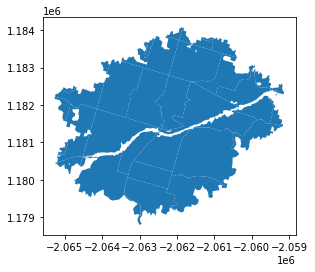

In [15]:
bbtc_bdy.plot()

In [16]:
bg_income=pd.merge(median_income,bbtc_bdy,left_on=['GISJOIN'],right_on=['GISJOIN'],how='inner')
bg_income

,GISJOIN,YEAR,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,COUNTYA,COUSUBA,PLACEA,...,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,G41000500203031,2013-2017,NaN,NaN,Oregon,41,Clackamas County,5,NaN,NaN,...,Block Group 1,G5030,S,653556.0,0.0,+45.4296716,-122.7202809,3423.318665,6.535584e+05,"MULTIPOLYGON (((-2062946.525 1179030.832, -206..."
1,G41005100060021,2013-2017,NaN,NaN,Oregon,41,Multnomah County,51,NaN,NaN,...,Block Group 1,G5030,S,1329086.0,0.0,+45.4751394,-122.6869770,4968.629375,1.329086e+06,"MULTIPOLYGON (((-2059326.793 1182300.127, -205..."
2,G41005100062001,2013-2017,NaN,NaN,Oregon,41,Multnomah County,51,NaN,NaN,...,Block Group 1,G5030,S,738057.0,0.0,+45.4676445,-122.6798022,4429.436472,7.380588e+05,"MULTIPOLYGON (((-2059183.122 1181438.976, -205..."
3,G41005100062002,2013-2017,NaN,NaN,Oregon,41,Multnomah County,51,NaN,NaN,...,Block Group 2,G5030,S,454002.0,0.0,+45.4659666,-122.6901358,3298.167094,4.540016e+05,"MULTIPOLYGON (((-2059333.976 1182288.201, -205..."
4,G41005100062003,2013-2017,NaN,NaN,Oregon,41,Multnomah County,51,NaN,NaN,...,Block Group 3,G5030,S,580808.0,0.0,+45.4606417,-122.6984605,4034.501185,5.808081e+05,"POLYGON ((-2059871.493 1181586.618, -2059896.0..."
5,G41005100063001,2013-2017,NaN,NaN,Oregon,41,Multnomah County,51,NaN,NaN,...,Block Group 1,G5030,S,3423283.0,586966.0,+45.4515701,-122.6662826,13080.086902,4.010249e+06,"POLYGON ((-2059194.092 1181408.487, -2059194.3..."
6,G41005100063003,2013-2017,NaN,NaN,Oregon,41,Multnomah County,51,NaN,NaN,...,Block Group 3,G5030,S,1098629.0,0.0,+45.4567931,-122.6879580,5548.165990,1.098631e+06,"POLYGON ((-2059474.133 1181499.765, -2059441.1..."
7,G41005100064021,2013-2017,NaN,NaN,Oregon,41,Multnomah County,51,NaN,NaN,...,Block Group 1,G5030,S,2263626.0,0.0,+45.4512873,-122.7014855,6525.275482,2.263626e+06,"POLYGON ((-2060483.300 1181251.566, -2060480.7..."
8,G41005100064022,2013-2017,NaN,NaN,Oregon,41,Multnomah County,51,NaN,NaN,...,Block Group 2,G5030,S,3535906.0,814.0,+45.4392262,-122.6970091,9670.964058,3.536722e+06,"POLYGON ((-2062067.897 1179195.813, -2062070.2..."
9,G41005100064031,2013-2017,NaN,NaN,Oregon,41,Multnomah County,51,NaN,NaN,...,Block Group 1,G5030,S,526304.0,0.0,+45.4432352,-122.7199305,3148.749732,5.263020e+05,"POLYGON ((-2062145.315 1180138.660, -2062146.4..."


In [17]:
pop=gpd.clip(bp,bdy, keep_geom_type=False)
pop.shape

(601, 143)

## HTC LTS14 Statistics Calculation

In [18]:
lts14=gpd.read_file('F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/Travel Time and Population Served/BBTC_LTS14_shortest_route.shp')
lts14.head()

,ObjectID,FacilityID,FacilityRa,Name,IncidentCu,FacilityCu,IncidentID,Total_Leng,geometry
0,1,5,1,G41000500203031000 - Location 1,1,2,602,3221.287226,"LINESTRING (2326367.185 198548.564, 2326365.11..."
1,2,5,1,G41000500203031001 - Location 1,1,2,603,3214.180694,"LINESTRING (2326364.754 198555.238, 2326362.84..."
2,3,5,1,G41000500203031002 - Location 1,1,2,604,3162.958877,"LINESTRING (2326223.829 198673.477, 2326223.82..."
3,4,5,1,G41005100060021014 - Location 1,2,2,605,4075.877788,"LINESTRING (2328759.081 203092.337, 2328764.06..."
4,5,5,1,G41005100060021017 - Location 1,2,2,606,4095.800807,"LINESTRING (2328523.971 203135.833, 2328529.49..."


In [19]:
lts14['bike_travel_time']=lts14['Total_Leng']*0.000621371/24*60
lts14.head()

,ObjectID,FacilityID,FacilityRa,Name,IncidentCu,FacilityCu,IncidentID,Total_Leng,geometry,bike_travel_time
0,1,5,1,G41000500203031000 - Location 1,1,2,602,3221.287226,"LINESTRING (2326367.185 198548.564, 2326365.11...",5.004036
1,2,5,1,G41000500203031001 - Location 1,1,2,603,3214.180694,"LINESTRING (2326364.754 198555.238, 2326362.84...",4.992997
2,3,5,1,G41000500203031002 - Location 1,1,2,604,3162.958877,"LINESTRING (2326223.829 198673.477, 2326223.82...",4.913427
3,4,5,1,G41005100060021014 - Location 1,2,2,605,4075.877788,"LINESTRING (2328759.081 203092.337, 2328764.06...",6.331581
4,5,5,1,G41005100060021017 - Location 1,2,2,606,4095.800807,"LINESTRING (2328523.971 203135.833, 2328529.49...",6.362530


In [20]:
lts14['bike_travel_time'].describe()

count    594.000000
mean       5.026839
std        2.042313
min        0.497292
25%        3.546121
50%        5.012685
75%        6.042054
max       10.352704
Name: bike_travel_time, dtype: float64

In [221]:
lts14[['GISJOIN','TC']]=lts14['Name'].str.split('-',expand=True)
lts14[['b','GISJOIN']]=lts14['GISJOIN'].str.split('G',expand=True)
lts14.head()

,ObjectID,FacilityID,FacilityRa,Name,IncidentCu,FacilityCu,IncidentID,Total_Leng,geometry,bike_travel_time,GISJOIN,TC,b
0,1,5,1,G41000500203031000 - Location 1,1,2,602,3221.287226,"LINESTRING (2326367.185 198548.564, 2326365.11...",6.004843,41000500203031000,Location 1,
1,2,5,1,G41000500203031001 - Location 1,1,2,603,3214.180694,"LINESTRING (2326364.754 198555.238, 2326362.84...",5.991596,41000500203031001,Location 1,
2,3,5,1,G41000500203031002 - Location 1,1,2,604,3162.958877,"LINESTRING (2326223.829 198673.477, 2326223.82...",5.896113,41000500203031002,Location 1,
3,4,5,1,G41005100060021014 - Location 1,2,2,605,4075.877788,"LINESTRING (2328759.081 203092.337, 2328764.06...",7.597897,41005100060021014,Location 1,
4,5,5,1,G41005100060021017 - Location 1,2,2,606,4095.800807,"LINESTRING (2328523.971 203135.833, 2328529.49...",7.635036,41005100060021017,Location 1,


In [222]:
lts14.shape

(594, 13)

In [223]:
lts14['GISJOIN']=lts14['GISJOIN'].astype(str).astype('int64')


In [224]:
lts14.shape,bp.shape

((594, 13), (15498, 143))

In [225]:
pop14=pd.merge(lts14,bp,left_on=['GISJOIN'],right_on=['GISJOIN'],how='inner')
pop14.shape

(594, 155)

In [226]:
pop14.head()

,ObjectID,FacilityID,FacilityRa,Name,IncidentCu,FacilityCu,IncidentID,Total_Leng,geometry_x,bike_travel_time,...,U7B064,U7B065,U7B066,U7B067,U7B068,U7B069,U7B070,U7B071,geometry_y,b_y
0,1,5,1,G41000500203031000 - Location 1,1,2,602,3221.287226,"LINESTRING (2326367.185 198548.564, 2326365.11...",6.004843,...,0,0,0,0,0,0,0,0,"POLYGON ((-2062734.913 1178966.439, -2062735.3...",
1,2,5,1,G41000500203031001 - Location 1,1,2,603,3214.180694,"LINESTRING (2326364.754 198555.238, 2326362.84...",5.991596,...,0,0,0,0,0,0,0,0,"POLYGON ((-2062985.516 1179042.744, -2063014.9...",
2,3,5,1,G41000500203031002 - Location 1,1,2,604,3162.958877,"LINESTRING (2326223.829 198673.477, 2326223.82...",5.896113,...,0,0,0,0,0,0,0,0,"POLYGON ((-2063140.352 1179090.009, -2063070.4...",
3,4,5,1,G41005100060021014 - Location 1,2,2,605,4075.877788,"LINESTRING (2328759.081 203092.337, 2328764.06...",7.597897,...,0,0,0,0,0,0,0,0,"POLYGON ((-2059425.832 1182979.745, -2059496.1...",
4,5,5,1,G41005100060021017 - Location 1,2,2,606,4095.800807,"LINESTRING (2328523.971 203135.833, 2328529.49...",7.635036,...,0,0,0,0,0,0,0,0,"POLYGON ((-2059735.280 1183070.638, -2059712.9...",


<AxesSubplot:>

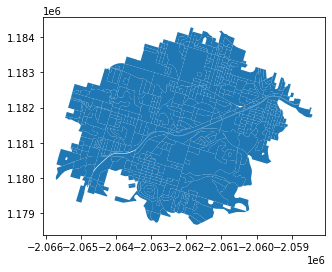

In [273]:
pop14=pop14.rename({'geometry_y':'geometry'},axis='columns')
pop14.plot()

# Calculate the served, unserved Population and income

In [228]:
pct_white14=pop14['U7B003'].sum()/pop14['U7B001'].sum()
pct_white14

0.789839258477062

In [229]:
pct_baf14=pop14['U7B004'].sum()/pop14['U7B001'].sum()
pct_baf14

0.028252962571864368

In [230]:
# percentage of served population
pct_pop14=pop14['U7B001'].sum()/pop['U7B001'].sum()*100
print('pct_pop14:',pct_pop14)

pct_pop14: 99.20385501780851


In [231]:
pop14.shape

(594, 155)

In [232]:
bg_income.shape

(33, 55)

In [233]:
pop14.crs

<Derived Projected CRS: EPSG:2838>
Name: NAD83(HARN) / Oregon North
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Oregon - counties of Baker; Benton; Clackamas; Clatsop; Columbia; Gilliam; Grant; Hood River; Jefferson; Lincoln; Linn; Marion; Morrow; Multnomah; Polk; Sherman; Tillamook; Umatilla; Union; Wallowa; Wasco; Washington; Wheeler; Yamhill.
- bounds: (-124.17, 43.95, -116.47, 46.26)
Coordinate Operation:
- name: SPCS83 Oregon North zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (High Accuracy Reference Network)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [234]:
pop14.head()

,ObjectID,FacilityID,FacilityRa,Name,IncidentCu,FacilityCu,IncidentID,Total_Leng,geometry_x,bike_travel_time,...,U7B064,U7B065,U7B066,U7B067,U7B068,U7B069,U7B070,U7B071,geometry,b_y
0,1,5,1,G41000500203031000 - Location 1,1,2,602,3221.287226,"LINESTRING (2326367.185 198548.564, 2326365.11...",6.004843,...,0,0,0,0,0,0,0,0,"POLYGON ((-2062734.913 1178966.439, -2062735.3...",
1,2,5,1,G41000500203031001 - Location 1,1,2,603,3214.180694,"LINESTRING (2326364.754 198555.238, 2326362.84...",5.991596,...,0,0,0,0,0,0,0,0,"POLYGON ((-2062985.516 1179042.744, -2063014.9...",
2,3,5,1,G41000500203031002 - Location 1,1,2,604,3162.958877,"LINESTRING (2326223.829 198673.477, 2326223.82...",5.896113,...,0,0,0,0,0,0,0,0,"POLYGON ((-2063140.352 1179090.009, -2063070.4...",
3,4,5,1,G41005100060021014 - Location 1,2,2,605,4075.877788,"LINESTRING (2328759.081 203092.337, 2328764.06...",7.597897,...,0,0,0,0,0,0,0,0,"POLYGON ((-2059425.832 1182979.745, -2059496.1...",
4,5,5,1,G41005100060021017 - Location 1,2,2,606,4095.800807,"LINESTRING (2328523.971 203135.833, 2328529.49...",7.635036,...,0,0,0,0,0,0,0,0,"POLYGON ((-2059735.280 1183070.638, -2059712.9...",


In [235]:
#pop14=pop14.to_crs('esri:102003',geometry=geometry)
#pop14=pop14.set_crs('esri:102003', geometry='geometry b_y')
#pop14.head()

<AxesSubplot:>

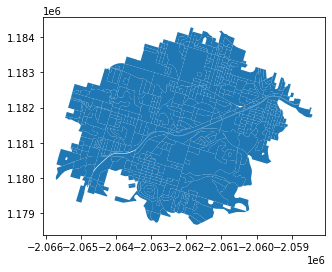

In [274]:
pop14.plot()

In [266]:
pop14.crs

<Derived Projected CRS: EPSG:2838>
Name: NAD83(HARN) / Oregon North
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Oregon - counties of Baker; Benton; Clackamas; Clatsop; Columbia; Gilliam; Grant; Hood River; Jefferson; Lincoln; Linn; Marion; Morrow; Multnomah; Polk; Sherman; Tillamook; Umatilla; Union; Wallowa; Wasco; Washington; Wheeler; Yamhill.
- bounds: (-124.17, 43.95, -116.47, 46.26)
Coordinate Operation:
- name: SPCS83 Oregon North zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (High Accuracy Reference Network)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [ ]:
bg_income1=bg_income.rename({'geometry_y':'geometry'},axis='columns')

<AxesSubplot:>

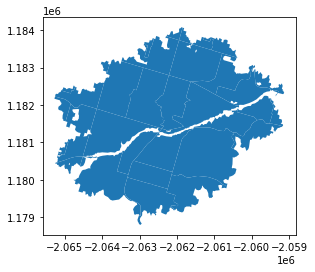

In [281]:
bg_income1.geometry.plot()

In [282]:
#bg_income1=gpd.GeoDataFrame(bg_income, geometry='geometry')
#bg_income1.head()

In [284]:
pop14.shape, bg_income1.shape

((594, 155), (33, 55))

In [305]:
# Portland income
income14=pop14.sjoin(bg_income1, how='inner')
income14.shape

C:\Users\mxm5116\.conda\envs\geo_env\lib\site-packages\geopandas\geodataframe.py:1938: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:2838
Right CRS: ESRI:102003

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


(1114, 210)

In [306]:
income14[['AH1PE001']].describe()

,AH1PE001
count,1114.000000
mean,86114.554758
std,26915.961034
min,31750.000000
25%,59803.000000
50%,89444.000000
75%,100956.000000
max,155703.000000


# HTS_LTS13_Statistics

In [21]:
lts13=gpd.read_file('F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/Travel Time and Population Served/BBTC_LTS13_shortest_route.shp')
lts13.head()

,ObjectID,FacilityID,FacilityRa,Name,IncidentCu,FacilityCu,IncidentID,Total_Leng,geometry
0,1,1,1,G41000500203031002 - Location 1,1,2,3,4065.908067,"LINESTRING (-122.72125 45.43306, -122.72124 45..."
1,2,1,1,G41005100060021014 - Location 1,2,2,4,6419.735411,"LINESTRING (-122.69036 45.47337, -122.69033 45..."
2,3,1,1,G41005100060021017 - Location 1,2,2,5,6438.869246,"LINESTRING (-122.69337 45.47369, -122.69334 45..."
3,4,1,1,G41005100060021018 - Location 1,2,2,6,6387.688613,"LINESTRING (-122.69430 45.47346, -122.69412 45..."
4,5,1,1,G41005100060021019 - Location 1,2,2,7,6370.143842,"LINESTRING (-122.69520 45.47354, -122.69501 45..."


In [22]:
lts13['bike_travel_time']=lts13['Total_Leng']*0.000621371/20*60
lts13.head()

,ObjectID,FacilityID,FacilityRa,Name,IncidentCu,FacilityCu,IncidentID,Total_Leng,geometry,bike_travel_time
0,1,1,1,G41000500203031002 - Location 1,1,2,3,4065.908067,"LINESTRING (-122.72125 45.43306, -122.72124 45...",7.579312
1,2,1,1,G41005100060021014 - Location 1,2,2,4,6419.735411,"LINESTRING (-122.69036 45.47337, -122.69033 45...",11.967112
2,3,1,1,G41005100060021017 - Location 1,2,2,5,6438.869246,"LINESTRING (-122.69337 45.47369, -122.69334 45...",12.002780
3,4,1,1,G41005100060021018 - Location 1,2,2,6,6387.688613,"LINESTRING (-122.69430 45.47346, -122.69412 45...",11.907373
4,5,1,1,G41005100060021019 - Location 1,2,2,7,6370.143842,"LINESTRING (-122.69520 45.47354, -122.69501 45...",11.874668


In [23]:
lts13['bike_travel_time'].describe()

count    563.000000
mean      10.132629
std        4.397433
min        0.648659
25%        7.600373
50%        9.833327
75%       12.629973
max       20.490143
Name: bike_travel_time, dtype: float64

In [296]:
lts13[['GISJOIN','TC']]=lts13['Name'].str.split('-',expand=True)
lts13[['b','GISJOIN']]=lts13['GISJOIN'].str.split('G',expand=True)
lts13.head()

,ObjectID,FacilityID,FacilityRa,Name,IncidentCu,FacilityCu,IncidentID,Total_Leng,geometry,bike_travel_time,GISJOIN,TC,b
0,1,1,1,G41000500203031002 - Location 1,1,2,3,4065.908067,"LINESTRING (-122.72125 45.43306, -122.72124 45...",9.474140,41000500203031002,Location 1,
1,2,1,1,G41005100060021014 - Location 1,2,2,4,6419.735411,"LINESTRING (-122.69036 45.47337, -122.69033 45...",14.958890,41005100060021014,Location 1,
2,3,1,1,G41005100060021017 - Location 1,2,2,5,6438.869246,"LINESTRING (-122.69337 45.47369, -122.69334 45...",15.003475,41005100060021017,Location 1,
3,4,1,1,G41005100060021018 - Location 1,2,2,6,6387.688613,"LINESTRING (-122.69430 45.47346, -122.69412 45...",14.884217,41005100060021018,Location 1,
4,5,1,1,G41005100060021019 - Location 1,2,2,7,6370.143842,"LINESTRING (-122.69520 45.47354, -122.69501 45...",14.843335,41005100060021019,Location 1,


In [298]:
lts13['GISJOIN']=lts13['GISJOIN'].astype(str).astype('int64')

In [299]:
pop13=pd.merge(lts13,bp,left_on=['GISJOIN'],right_on=['GISJOIN'],how='inner')
pop13.shape

(563, 155)

In [300]:
pct_white13=pop13['U7B003'].sum()/pop13['U7B001'].sum()
pct_baf=pop13['U7B004'].sum()/pop13['U7B001'].sum()
print('pct_baf:',pct_baf)
print('pct_white:',pct_white13)

pct_baf: 0.02888905506119295
pct_white: 0.7893267529100925


<AxesSubplot:>

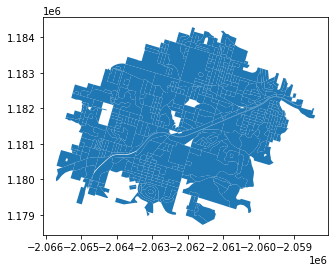

In [301]:
pop13=pop13.rename({'geometry_y':'geometry'},axis='columns')
pop13.plot()

In [303]:
# Portland income
income13=pop13.sjoin(bg_income1, how='inner')
income13.shape

C:\Users\mxm5116\.conda\envs\geo_env\lib\site-packages\geopandas\geodataframe.py:1938: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: ESRI:102003

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


(1043, 210)

In [304]:
income13[['AH1PE001']].describe()

,AH1PE001
count,1043.000000
mean,85527.721956
std,27030.601625
min,31750.000000
25%,59803.000000
50%,89444.000000
75%,100956.000000
max,155703.000000


In [307]:
# percentage of served population
pct_pop13=pop13['U7B001'].sum()/pop['U7B001'].sum()*100
print('pct_pop13:',pct_pop13)

pct_pop13: 93.3933933933934


# HTS_LTS12_Statistics

In [24]:
lts12=gpd.read_file('F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/Travel Time and Population Served/BBTC_LTS12_shortest_route.shp')
lts12.head()

,ObjectID,FacilityID,FacilityRa,Name,IncidentCu,FacilityCu,IncidentID,Total_Leng,geometry
0,1,1,1,G41005100064032001 - Location 1,1,2,168,347.971837,"LINESTRING (-122.71564 45.45375, -122.71542 45..."
1,2,1,1,G41005100064032002 - Location 1,2,2,169,447.365778,"LINESTRING (-122.72027 45.45107, -122.71906 45..."
2,3,1,1,G41005100064032003 - Location 1,2,2,170,700.430870,"LINESTRING (-122.72206 45.44985, -122.72201 45..."
3,4,1,1,G41005100064032004 - Location 1,1,2,171,630.935674,"LINESTRING (-122.72161 45.45032, -122.72159 45..."
4,5,1,1,G41005100064032005 - Location 1,2,2,172,451.146547,"LINESTRING (-122.71907 45.45017, -122.71906 45..."


In [25]:
lts12['bike_travel_time']=lts12['Total_Leng']*0.000621371/14*60
lts12.head()

,ObjectID,FacilityID,FacilityRa,Name,IncidentCu,FacilityCu,IncidentID,Total_Leng,geometry,bike_travel_time
0,1,1,1,G41005100064032001 - Location 1,1,2,168,347.971837,"LINESTRING (-122.71564 45.45375, -122.71542 45...",0.926655
1,2,1,1,G41005100064032002 - Location 1,2,2,169,447.365778,"LINESTRING (-122.72027 45.45107, -122.71906 45...",1.191343
2,3,1,1,G41005100064032003 - Location 1,2,2,170,700.430870,"LINESTRING (-122.72206 45.44985, -122.72201 45...",1.865260
3,4,1,1,G41005100064032004 - Location 1,1,2,171,630.935674,"LINESTRING (-122.72161 45.45032, -122.72159 45...",1.680193
4,5,1,1,G41005100064032005 - Location 1,2,2,172,451.146547,"LINESTRING (-122.71907 45.45017, -122.71906 45...",1.201412


In [26]:
lts12['bike_travel_time'].describe()

count    16.000000
mean      2.675731
std       1.210966
min       0.926655
25%       1.560498
50%       2.947174
75%       3.611462
max       4.297408
Name: bike_travel_time, dtype: float64

In [312]:
lts12[['GISJOIN','TC']]=lts12['Name'].str.split('-',expand=True)
lts12[['b','GISJOIN']]=lts12['GISJOIN'].str.split('G',expand=True)
lts12.head()

,ObjectID,FacilityID,FacilityRa,Name,IncidentCu,FacilityCu,IncidentID,Total_Leng,geometry,bike_travel_time,GISJOIN,TC,b
0,1,1,1,G41005100064032001 - Location 1,1,2,168,347.971837,"LINESTRING (-122.71564 45.45375, -122.71542 45...",0.864878,41005100064032001,Location 1,
1,2,1,1,G41005100064032002 - Location 1,2,2,169,447.365778,"LINESTRING (-122.72027 45.45107, -122.71906 45...",1.111920,41005100064032002,Location 1,
2,3,1,1,G41005100064032003 - Location 1,2,2,170,700.430870,"LINESTRING (-122.72206 45.44985, -122.72201 45...",1.740910,41005100064032003,Location 1,
3,4,1,1,G41005100064032004 - Location 1,1,2,171,630.935674,"LINESTRING (-122.72161 45.45032, -122.72159 45...",1.568181,41005100064032004,Location 1,
4,5,1,1,G41005100064032005 - Location 1,2,2,172,451.146547,"LINESTRING (-122.71907 45.45017, -122.71906 45...",1.121318,41005100064032005,Location 1,


In [313]:
lts12['GISJOIN']=lts12['GISJOIN'].astype(str).astype('int64')
pop12=pd.merge(lts12,bp,left_on=['GISJOIN'],right_on=['GISJOIN'],how='inner')
pop12.shape

(16, 155)

In [314]:
pct_white12=pop12['U7B003'].sum()/pop12['U7B001'].sum()
pct_baf12=pop12['U7B004'].sum()/pop12['U7B001'].sum()
print('pct_baf12:',pct_baf12)
print('pct_white12:',pct_white12)

pct_baf12: 0.112565445026178
pct_white12: 0.6767015706806283


<AxesSubplot:>

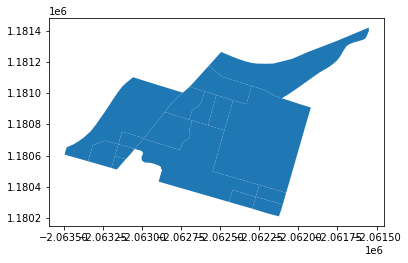

In [315]:
pop12=pop12.rename({'geometry_y':'geometry'},axis='columns')
pop12.plot()

In [316]:
# Portland income
income12=pop12.sjoin(bg_income1, how='inner')
income12.shape

C:\Users\mxm5116\.conda\envs\geo_env\lib\site-packages\geopandas\geodataframe.py:1938: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: ESRI:102003

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


(34, 210)

In [317]:
income12[['AH1PE001']].describe()

,AH1PE001
count,34.000000
mean,70525.411765
std,37178.805451
min,50000.000000
25%,50000.000000
50%,50903.000000
75%,68038.250000
max,155703.000000


In [329]:
# percentage of served population
pct_pop12=pop12['U7B001'].sum()/pop['U7B001'].sum()*100
print('pct_pop12:',pct_pop12)

pct_pop12: 5.335568126265801


## Only LTS1

In [27]:
lts1=gpd.read_file('F:/Paper-5_1 Bicycle Network Connectivity Measures/pybna/Stress Shape File/Travel Time and Population Served/BBTC_LTS1_shortest_route.shp')
lts1.head()

,ObjectID,FacilityID,FacilityRa,Name,IncidentCu,FacilityCu,IncidentID,Total_Leng,geometry
0,1,1,1,G41005100064032001 - Location 1,1,2,168,347.971837,"LINESTRING (-122.71564 45.45375, -122.71542 45..."
1,2,1,1,G41005100064032002 - Location 1,2,2,169,447.365778,"LINESTRING (-122.72027 45.45107, -122.71906 45..."
2,3,1,1,G41005100064032003 - Location 1,2,2,170,700.430870,"LINESTRING (-122.72206 45.44985, -122.72201 45..."
3,4,1,1,G41005100064032004 - Location 1,1,2,171,630.935674,"LINESTRING (-122.72161 45.45032, -122.72159 45..."
4,5,1,1,G41005100064032005 - Location 1,2,2,172,451.146547,"LINESTRING (-122.71907 45.45017, -122.71906 45..."


In [28]:
lts1['bike_travel_time']=lts1['Total_Leng']*0.000621371/10*60
lts1.head()

,ObjectID,FacilityID,FacilityRa,Name,IncidentCu,FacilityCu,IncidentID,Total_Leng,geometry,bike_travel_time
0,1,1,1,G41005100064032001 - Location 1,1,2,168,347.971837,"LINESTRING (-122.71564 45.45375, -122.71542 45...",1.297318
1,2,1,1,G41005100064032002 - Location 1,2,2,169,447.365778,"LINESTRING (-122.72027 45.45107, -122.71906 45...",1.667881
2,3,1,1,G41005100064032003 - Location 1,2,2,170,700.430870,"LINESTRING (-122.72206 45.44985, -122.72201 45...",2.611365
3,4,1,1,G41005100064032004 - Location 1,1,2,171,630.935674,"LINESTRING (-122.72161 45.45032, -122.72159 45...",2.352271
4,5,1,1,G41005100064032005 - Location 1,2,2,172,451.146547,"LINESTRING (-122.71907 45.45017, -122.71906 45...",1.681976


In [29]:
lts1['bike_travel_time'].describe()

count    16.000000
mean      3.746023
std       1.695353
min       1.297318
25%       2.184697
50%       4.126044
75%       5.056047
max       6.016371
Name: bike_travel_time, dtype: float64

In [333]:
lts1[['GISJOIN','TC']]=lts1['Name'].str.split('-',expand=True)
lts1[['b','GISJOIN']]=lts1['GISJOIN'].str.split('G',expand=True)
lts1.head()

,ObjectID,FacilityID,FacilityRa,Name,IncidentCu,FacilityCu,IncidentID,Total_Leng,geometry,bike_travel_time,GISJOIN,TC,b
0,1,1,1,G41005100064032001 - Location 1,1,2,168,347.971837,"LINESTRING (-122.71564 45.45375, -122.71542 45...",1.081098,41005100064032001,Location 1,
1,2,1,1,G41005100064032002 - Location 1,2,2,169,447.365778,"LINESTRING (-122.72027 45.45107, -122.71906 45...",1.389901,41005100064032002,Location 1,
2,3,1,1,G41005100064032003 - Location 1,2,2,170,700.430870,"LINESTRING (-122.72206 45.44985, -122.72201 45...",2.176137,41005100064032003,Location 1,
3,4,1,1,G41005100064032004 - Location 1,1,2,171,630.935674,"LINESTRING (-122.72161 45.45032, -122.72159 45...",1.960226,41005100064032004,Location 1,
4,5,1,1,G41005100064032005 - Location 1,2,2,172,451.146547,"LINESTRING (-122.71907 45.45017, -122.71906 45...",1.401647,41005100064032005,Location 1,


In [334]:
lts1['GISJOIN']=lts1['GISJOIN'].astype(str).astype('int64')
pop1=pd.merge(lts1,bp,left_on=['GISJOIN'],right_on=['GISJOIN'],how='inner')
pop1.shape

(16, 155)

In [335]:
pct_white1=pop1['U7B003'].sum()/pop1['U7B001'].sum()
pct_baf1=pop1['U7B004'].sum()/pop1['U7B001'].sum()
print('pct_baf1:',pct_baf1)
print('pct_white1:',pct_white1)

pct_baf1: 0.112565445026178
pct_white1: 0.6767015706806283


<AxesSubplot:>

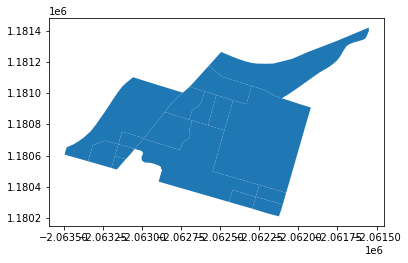

In [337]:
pop1=pop1.rename({'geometry_y':'geometry'},axis='columns')
pop1.plot()

In [338]:
# Portland income
income1=pop1.sjoin(bg_income1, how='inner')
income1.shape

C:\Users\mxm5116\.conda\envs\geo_env\lib\site-packages\geopandas\geodataframe.py:1938: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: ESRI:102003

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


(34, 210)

In [339]:
income1[['AH1PE001']].describe()

,AH1PE001
count,34.000000
mean,70525.411765
std,37178.805451
min,50000.000000
25%,50000.000000
50%,50903.000000
75%,68038.250000
max,155703.000000


In [340]:
# percentage of served population
pct_pop1=pop1['U7B001'].sum()/pop['U7B001'].sum()*100
print('pct_pop1:',pct_pop1)

pct_pop1: 5.335568126265801
